# PVI demo on the adult dataset
Using the codebase splits as in <https://github.com/MrinankSharma/DP-PVI>

In [41]:
%load_ext autoreload
%autoreload 2

import os
import sys
import logging

module_path = os.path.abspath(os.path.join("../.."))
if module_path not in sys.path:
    sys.path.append(module_path)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [42]:
from pvi.models.logistic_regression import LogisticRegressionModel
from pvi.utils.gaussian import mvstandard2natural, mvnatural2standard

#!!!Problem synchronous client is not defined!!!
#from pvi.clients.synchronous_client import SynchronousClient
#!!!Problem synchronous client is not defined!!!
# Try instead:
from pvi.clients.base import Client

from pvi.servers.sequential_server import SequentialServer
from pvi.distributions.exponential_family_distributions import \
    MultivariateGaussianDistribution, MeanFieldGaussianDistribution
from pvi.distributions.exponential_family_factors import \
    MultivariateGaussianFactor, MeanFieldGaussianFactor

import torch
import numpy as np
import matplotlib.pyplot as plt
import tqdm.auto as tqdm

from torch import nn

%matplotlib inline
torch.set_default_dtype(torch.float64)

### Set up data and helper functions

In [43]:
def generate_filename(name, scaled, ordinal_cat_encoding, data_base_dir):
    filename_x = "x"
    ret_y = data_base_dir + name + "/y.csv"
    if scaled:
        filename_x = filename_x + "_scaled"

    if ordinal_cat_encoding:
        filename_x = filename_x + "_ordinal"

    filename_x = filename_x + ".csv"
    ret = os.path.join(data_base_dir, name, filename_x)
    ret_y = os.path.join(data_base_dir, name, "y.csv")
    
    return ret, ret_y

def load_data(name, scaled, ordinal_cat_encoding, train_proportion, data_base_dir):
    x_loc, y_loc = generate_filename(name, scaled, ordinal_cat_encoding, data_base_dir)
    x = np.loadtxt(x_loc, delimiter=",")
    y = np.loadtxt(y_loc, delimiter=",")
    
    # Replace -1's with 0's.
    y[y == -1] = 0
    
    N = x.shape[0]
    N_train = int(np.ceil(train_proportion * N))
    
    x_train = x[0:N_train]
    y_train = y[0:N_train]
    x_test = x[N_train:]
    y_test = y[N_train:]

    training_set = {
        "x": x_train,
        "y": y_train,
    }

    test_set = {
        "x": x_test,
        "y": y_test
    }

    D = x_test.shape[1]

    return training_set, test_set, D

def generate_clients_data(x, y, M, client_size_factor, class_balance_factor, dataset_seed):
        # this function ought to return a list of (x, y) tuples.
        # you need to set the seed in the main experiment file to ensure that this function becomes deterministic

        random_state = np.random.get_state()

        if dataset_seed is not None:
            np.random.seed(dataset_seed)

        if M == 1:
            client_data = [{"x": x, "y": y}]
            N_is = [x.shape[0]]
            props_positive = [np.mean(y > 0)]

            return client_data, N_is, props_positive, M

        if M % 2 != 0: raise ValueError('Num clients should be even for nice maths')

        N = x.shape[0]
        small_client_size = int(np.floor((1 - client_size_factor) * N/M))
        big_client_size = int(np.floor((1 + client_size_factor) * N/M))

        class_balance = np.mean(y == 0)

        small_client_class_balance = class_balance + (1 - class_balance) * class_balance_factor
        small_client_negative_class_size = int(np.floor(small_client_size * small_client_class_balance))
        small_client_positive_class_size = int(small_client_size - small_client_negative_class_size)

        if small_client_negative_class_size < 0: raise ValueError('small_client_negative_class_size is negative, invalid settings.')
        if small_client_positive_class_size < 0: raise ValueError('small_client_positive_class_size is negative, invalid settings.')


        if small_client_negative_class_size * M/2 > class_balance * N:
            raise ValueError(f'Not enough negative class instances to fill the small clients. Client size factor:{client_size_factor}, class balance factor:{class_balance_factor}')

        if small_client_positive_class_size * M/2 > (1-class_balance) * N:
            raise ValueError(f'Not enough positive class instances to fill the small clients. Client size factor:{client_size_factor}, class balance factor:{class_balance_factor}')


        pos_inds = np.where(y > 0)
        zero_inds = np.where(y == 0)
        
        assert (len(pos_inds[0]) + len(zero_inds[0])) == len(y), "Some indeces missed."
        
        print(f'x shape {x.shape}')
        print(f'positive indices {pos_inds}')
        print(f'zero indices {zero_inds}')

        y_pos = y[pos_inds]
        y_neg = y[zero_inds]

        x_pos = x[pos_inds]
        x_neg = x[zero_inds]

        client_data = []

        # Populate small classes.
        for i in range(int(M/2)):
            client_x_pos = x_pos[:small_client_positive_class_size]
            x_pos = x_pos[small_client_positive_class_size:]
            client_y_pos = y_pos[:small_client_positive_class_size]
            y_pos = y_pos[small_client_positive_class_size:]

            client_x_neg = x_neg[:small_client_negative_class_size]
            x_neg = x_neg[small_client_negative_class_size:]
            client_y_neg = y_neg[:small_client_negative_class_size]
            y_neg = y_neg[small_client_negative_class_size:]

            client_x = np.concatenate([client_x_pos, client_x_neg])
            client_y = np.concatenate([client_y_pos, client_y_neg])

            shuffle_inds = np.random.permutation(client_x.shape[0])

            client_x = client_x[shuffle_inds, :]
            client_y = client_y[shuffle_inds]

            client_data.append({'x': client_x, 'y': client_y})

        # Recombine remaining data and shuffle.

        x = np.concatenate([x_pos, x_neg])
        y = np.concatenate([y_pos, y_neg])
        shuffle_inds = np.random.permutation(x.shape[0])

        x = x[shuffle_inds]
        y = y[shuffle_inds]

        # Distribute among large clients.
        for i in range(int(M/2)):
            client_x = x[:big_client_size]
            client_y = y[:big_client_size]

            x = x[big_client_size:]
            y = y[big_client_size:]

            client_data.append({'x': client_x, 'y': client_y})

        N_is = [data['x'].shape[0] for data in client_data]
        props_positive = [np.mean(data['y'] > 0) for data in client_data]

        np.random.set_state(random_state)

        print(f'N_is {N_is}')
        print(f'Props positive: {props_positive}')

        return client_data, N_is, props_positive, M

In [44]:
name = "adult"
scaled = True
ordinal_cat_encoding = True
train_proportion = 0.75
data_base_dir = "/Users/terjemildner/Desktop/PVI-main/data"

training_set, test_set, D = load_data(
    name, scaled, ordinal_cat_encoding, train_proportion, data_base_dir)
print(len(training_set['x']))

24421


In [45]:
M = 10

clients_data, nis, prop_positive, M = generate_clients_data(
    training_set["x"], 
    training_set["y"],
    M=M,
    client_size_factor=0,
    class_balance_factor=0,
    dataset_seed=0,
)

x shape (24421, 14)
positive indices (array([    4,     8,    12, ..., 24409, 24410, 24412]),)
zero indices (array([    0,     1,     2, ..., 24418, 24419, 24420]),)
N_is [2442, 2442, 2442, 2442, 2442, 2442, 2442, 2442, 2442, 2442]
Props positive: [0.24324324324324326, 0.24324324324324326, 0.24324324324324326, 0.24324324324324326, 0.24324324324324326, 0.23996723996723995, 0.24283374283374284, 0.24242424242424243, 0.23546273546273547, 0.25184275184275184]


### Set up clients

In [46]:
clients = []

# Shared across all clients.
hyperparameters = {
    "D": D,
    "optimiser": "Adam",
    "optimiser_params": {"lr": 1e-2},
    "epochs": 1000,
    "batch_size": 100,
    "num_elbo_samples": 100,
    "num_predictive_samples": 10
}

prior_std_params = {
    "loc": torch.zeros(hyperparameters["D"] + 1),
    "scale": torch.ones(hyperparameters["D"] + 1),
}

init_nat_params = {
    "np1": torch.zeros(hyperparameters["D"] + 1),
    "np2": torch.zeros(hyperparameters["D"] + 1),
}

# Construct clients.
for i in range(M):
    model_i = LogisticRegressionModel(hyperparameters=hyperparameters)
    data_i = clients_data[i]
    t_i = MeanFieldGaussianFactor(nat_params=init_nat_params)
    
    # Convert to torch.tensor.
    for k, v in data_i.items():
        data_i[k] = torch.tensor(v)
    
    # clients.append(SynchronousClient(data=data_i, model=model_i, t=t_i))
    clients.append(Client(data=data_i, model=model_i, t=t_i))

In [47]:
# Construct server.
model = LogisticRegressionModel(hyperparameters=hyperparameters)
q = MeanFieldGaussianDistribution(std_params=prior_std_params, is_trainable=False)
server = SequentialServer(model=model, p=q, clients=clients)

### Run PVI!

In [48]:
while not server.should_stop():
    server.tick()

    # Obtain predictions.
    pp = server.model_predict(torch.tensor(test_set["x"]))
    preds = pp.mean.detach().numpy()
    test_acc = np.sum(
        np.abs(2 * (preds > 0.5) - 1 + test_set["y"]) > 0) / np.size(test_set["y"])
    
    print(test_acc)

0it [00:00, ?it/s]

0.8680589680589681


0it [00:00, ?it/s]

0.8714987714987715


0it [00:00, ?it/s]

0.8621621621621621


0it [00:00, ?it/s]

0.8816953316953317


0it [00:00, ?it/s]

0.8756756756756757


0it [00:00, ?it/s]

0.878009828009828


0it [00:00, ?it/s]

0.8660933660933661


0it [00:00, ?it/s]

0.8746928746928747


0it [00:00, ?it/s]

0.8733415233415234


0it [00:00, ?it/s]

0.8769041769041769


0it [00:00, ?it/s]

0.8724815724815724


0it [00:00, ?it/s]

0.8605651105651105


0it [00:00, ?it/s]

0.8678132678132678


0it [00:00, ?it/s]

0.8606879606879607


0it [00:00, ?it/s]

0.8986486486486487


0it [00:00, ?it/s]

0.8642506142506142


0it [00:00, ?it/s]

0.871007371007371


0it [00:00, ?it/s]

0.8644963144963145


0it [00:00, ?it/s]

0.8891891891891892


0it [00:00, ?it/s]

0.8735872235872236


0it [00:00, ?it/s]

0.8832923832923832


0it [00:00, ?it/s]

0.8702702702702703


0it [00:00, ?it/s]

0.8555282555282555


0it [00:00, ?it/s]

0.8658476658476658


0it [00:00, ?it/s]

0.8646191646191647


In [49]:
def plot_training(training_array, ax=None):
    x_vals = np.arange(1, len(training_array)+1)
    print(training_array)
    if ax is None:
        plt.figure()
        ax = plt.gca()
        
    ax.grid(visible=True)
    ax.plot(x_vals, training_array)
    ax.set_xlabel('Step')
    
    if ax is None:
        plt.show()

In [58]:
logs = server.get_compiled_log()

defaultdict(<class 'list'>, {'training_curves': [defaultdict(<class 'list'>, {'elbo': [0.2764916835512618], 'kl': [-0.6853669900642175], 'll': [-0.40887530651295584], 'logt': [0.0]}), defaultdict(<class 'list'>, {'elbo': [1.337797747130814], 'kl': [-1.744533195711628], 'll': [-0.4067354485808138], 'logt': [0.0]}), defaultdict(<class 'list'>, {'elbo': [2.259633121262843], 'kl': [-2.667351312815337], 'll': [-0.40771819155249406], 'logt': [0.0]}), defaultdict(<class 'list'>, {'elbo': [1.36341385135389], 'kl': [-1.7699591223751334], 'll': [-0.40654527102124355], 'logt': [0.0]}), defaultdict(<class 'list'>, {'elbo': [1.7264419707086078], 'kl': [-2.1388981757843255], 'll': [-0.4124562050757179], 'logt': [0.0]}), defaultdict(<class 'list'>, {'elbo': [1.9820965597250615], 'kl': [-2.392385978529198], 'll': [-0.41028941880413644], 'logt': [0.0]}), defaultdict(<class 'list'>, {'elbo': [2.059191806162171], 'kl': [-2.4746850491265104], 'll': [-0.4154932429643397], 'logt': [0.0]}), defaultdict(<clas

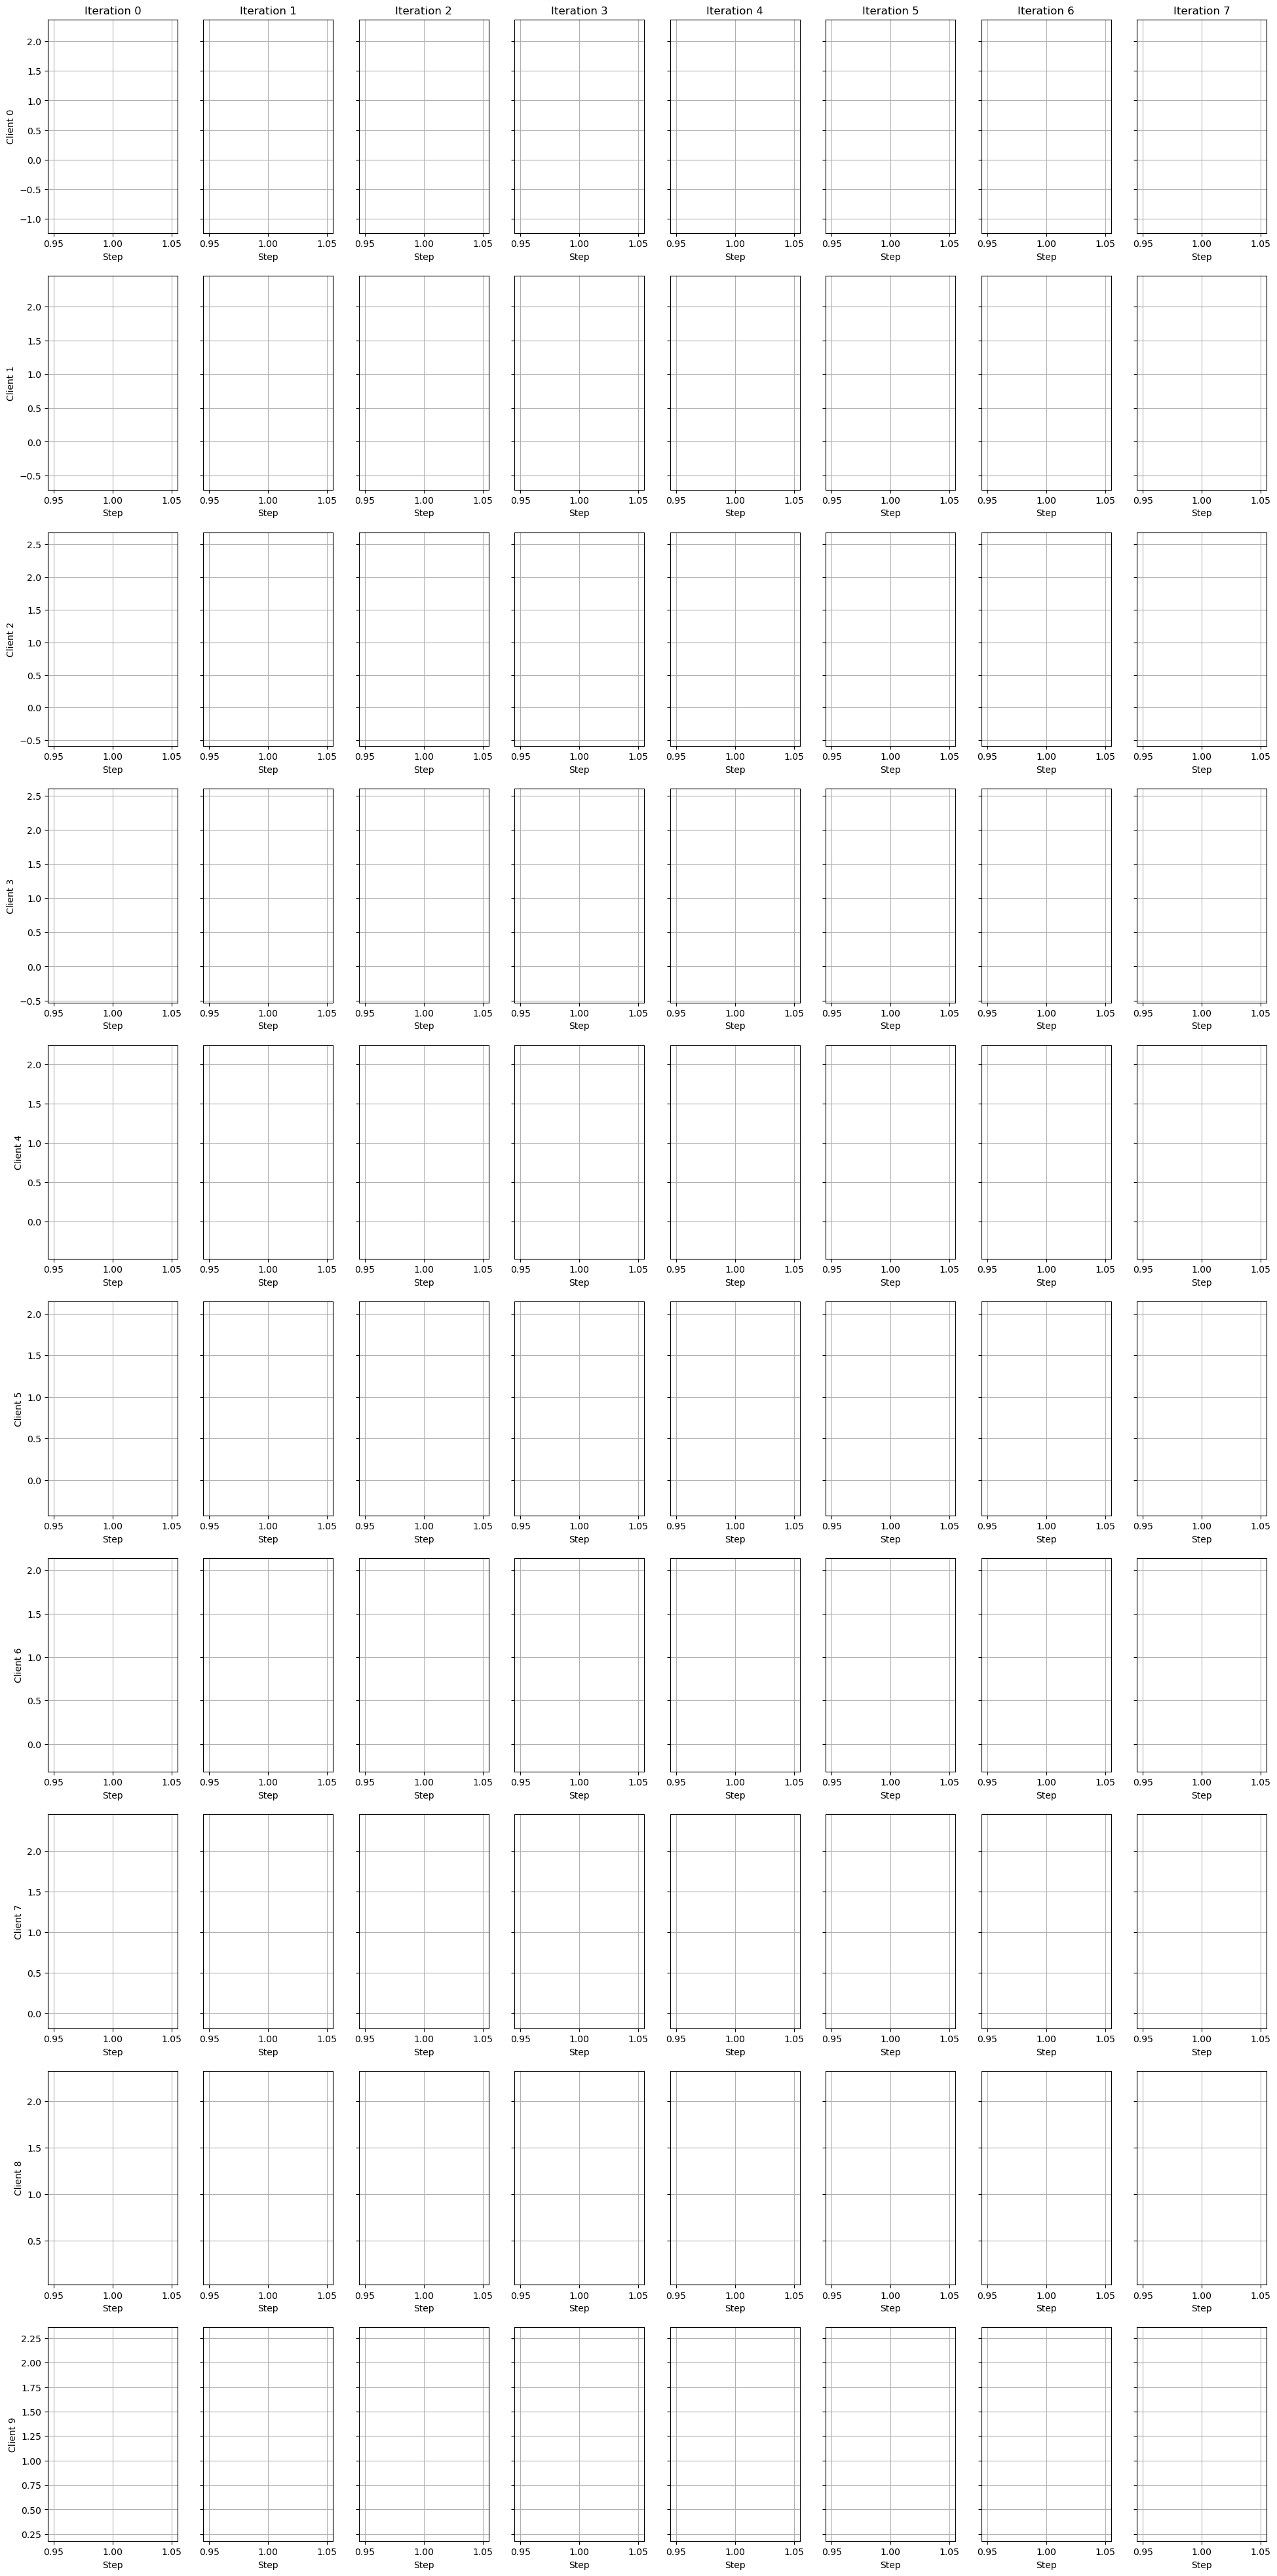

In [52]:
nrows = len(clients)
ncols = 8

fig, axes = plt.subplots(figsize=(ncols*3, nrows*5), nrows=nrows, ncols=ncols, sharey="row")

print(client.log)
for i, client in enumerate(server.clients):
    print("client ", i)
    for j in range(ncols):
        ax = axes[i, j]
        
        print(logs[f"client_{i}"]["training_curves"][j])
        print("=======================")
        plot_training(logs[f"client_{i}"]["training_curves"][j]["elbo"], ax)
        
    axes[i, 0].set_ylabel("Client {}".format(i))
    
for j in range(ncols):
    axes[0, j].set_title("Iteration {}".format(j))
        
        
plt.show()